In [1]:
import tensorflow

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import numpy as np

In [3]:
batch_size = 64
epochs = 10
latent_dim = 256
num_samples = 40000

In [4]:
data_path = 'train_data.txt'

In [5]:
input_texts = []
output_texts = []
input_characters = set()
output_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[:min(num_samples,len(lines)-1)]:
    input_text, output_text= line.split('\t')
    
    # We use 'tab' as the 'start sequence' character
    # for the targets, and '\n' as the 'end sequence' character.
    
    output_text = '\t' + output_text + '\n'
    input_texts.append(input_text)
    output_texts.append(output_text)

    
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in output_text:
        if char not in output_characters:
            output_characters.add(char)

In [6]:
len(output_characters)

94

In [7]:
input_characters = sorted(input_characters)
output_characters = sorted(output_characters)
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(output_characters)

In [8]:
max_encoder_seq_length = max(len(text) for text in input_texts)
max_decoder_seq_length = max(len(text) for text in output_texts)

In [9]:
print("Number of Samples:", len(input_texts))
print('Number of unique input Tokens:', num_encoder_tokens)
print('Number of unique output Tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of Samples: 40000
Number of unique input Tokens: 167
Number of unique output Tokens: 94
Max sequence length for inputs: 193
Max sequence length for outputs: 192


In [10]:
input_token_index = {char: i for i, char in enumerate(input_characters)}
output_token_index = {char: i for i, char in enumerate(output_characters)}

In [11]:
input_token_index , output_token_index

({' ': 0,
  '!': 1,
  '"': 2,
  '$': 3,
  '%': 4,
  '&': 5,
  "'": 6,
  ',': 7,
  '-': 8,
  '.': 9,
  '/': 10,
  '0': 11,
  '1': 12,
  '2': 13,
  '3': 14,
  '4': 15,
  '5': 16,
  '6': 17,
  '7': 18,
  '8': 19,
  '9': 20,
  ':': 21,
  ';': 22,
  '?': 23,
  'A': 24,
  'B': 25,
  'C': 26,
  'D': 27,
  'E': 28,
  'F': 29,
  'G': 30,
  'H': 31,
  'I': 32,
  'J': 33,
  'K': 34,
  'L': 35,
  'M': 36,
  'N': 37,
  'O': 38,
  'P': 39,
  'Q': 40,
  'R': 41,
  'S': 42,
  'T': 43,
  'U': 44,
  'V': 45,
  'X': 46,
  'Y': 47,
  'Z': 48,
  'a': 49,
  'b': 50,
  'c': 51,
  'd': 52,
  'e': 53,
  'f': 54,
  'g': 55,
  'h': 56,
  'i': 57,
  'j': 58,
  'k': 59,
  'l': 60,
  'm': 61,
  'n': 62,
  'o': 63,
  'p': 64,
  'q': 65,
  'r': 66,
  's': 67,
  't': 68,
  'u': 69,
  'v': 70,
  'w': 71,
  'x': 72,
  'y': 73,
  'z': 74,
  '°': 75,
  'Á': 76,
  'Â': 77,
  'Ô': 78,
  'Ú': 79,
  'Ý': 80,
  'à': 81,
  'á': 82,
  'â': 83,
  'ã': 84,
  'ç': 85,
  'è': 86,
  'é': 87,
  'ê': 88,
  'ì': 89,
  'í': 90,
  'ò': 91

In [12]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype='float16')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float16')
decoder_output_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float16')


In [13]:
for i,(input_text,output_text) in enumerate(zip(input_texts, output_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i,t,input_token_index[char]] = 1.
    encoder_input_data[i,t+1:,input_token_index[' ']] = 1.
    
    for t, char in enumerate(output_text):
        # decoder_output_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i,t,output_token_index[char]] = 1.
        if t>0:
            # decoder_output_data will be ahead by one timestep
            # and will not include the start character
            decoder_output_data[i,t-1,output_token_index[char]] = 1.
    decoder_input_data[i,t+1:, output_token_index[' ']] = 1.
    decoder_output_data[i , t: , output_token_index[' ']] = 1.

In [14]:
encoder_input_data[0].shape

(193, 167)

In [15]:
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = GRU(latent_dim, return_state=True)
encoder_outputs, state = encoder(encoder_inputs)
encoder_states = [state]

In [16]:
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_gru = GRU(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, state = decoder_gru(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [17]:
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

In [18]:
model = tensorflow.keras.models.Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss = 'categorical_crossentropy' , metrics = ['accuracy',f1_score])
model = model.fit([encoder_input_data,decoder_input_data], decoder_output_data,
         batch_size=batch_size,
         epochs = epochs,
         validation_split=0.2)
train_acc = model.history['accuracy']
val_acc = model.history['val_accuracy']
train_f1 = model.history['f1_score']
val_f1 = model.history['val_f1_score']

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 842s 2s/step - accuracy: 0.8399 - f1_score: 0.8475 - loss: 0.8006 - val_accuracy: 0.8676 - val_f1_score: 0.9001 - val_loss: 0.4694
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 807s 2s/step - accuracy: 0.8785 - f1_score: 0.9061 - loss: 0.4283 - val_accuracy: 0.8849 - val_f1_score: 0.9099 - val_loss: 0.3940
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 805s 2s/step - accuracy: 0.8865 - f1_score: 0.9120 - loss: 0.3874 - val_accuracy: 0.8897 - val_f1_score: 0.9144 - val_loss: 0.3741
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 710s 1s/step - accuracy: 0.8917 - f1_score: 0.9152 - loss: 0.3671 - val_accuracy: 0.8955 - val_f1_score: 0.9169 - val_loss: 0.3556
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 762s 2s/step - accuracy: 0.8959 - f1_score: 0.9177 - loss: 0.3517 - val_accuracy: 0.8993 - val_f1_score: 0.9193 - val_loss: 0.3421
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 728s 1s/step - accuracy: 0.9002 - f1_score: 0.9206 - loss: 0.3363 - val_accuracy: 0.9025 - val_f1_score: 

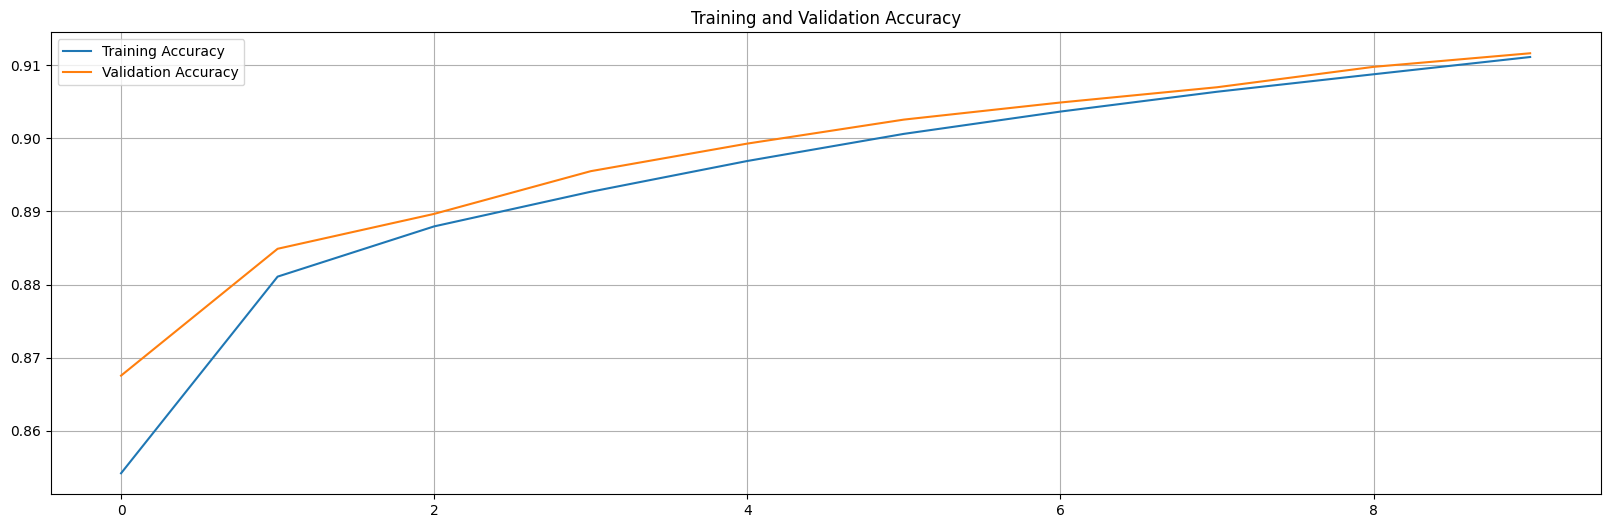

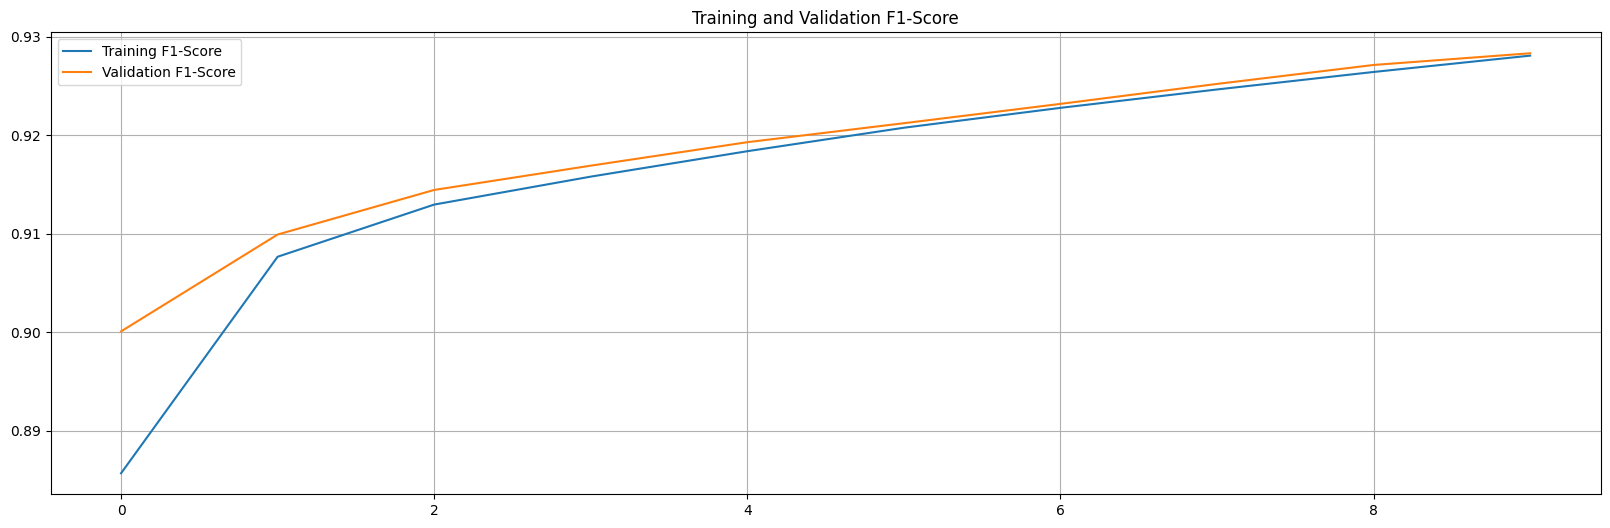

In [19]:
epochs_range = range(epochs)
plt.figure(figsize=(20, 6))

plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(20, 6))
plt.plot(epochs_range, train_f1, label='Training F1-Score')
plt.plot(epochs_range, val_f1, label='Validation F1-Score')
plt.title('Training and Validation F1-Score')
plt.legend()
plt.grid(True)
plt.show()